In [1]:
# Disable GPU to avoid TensorFlow GPU issues
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Core Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import warnings
warnings.filterwarnings('ignore')

# Stock data
import yfinance as yf

# Preprocessing
from sklearn.preprocessing import MinMaxScaler

# Deep Learning
from keras.models import Sequential
from keras.layers import Dense, LSTM

print("Libraries imported successfully!")


Libraries imported successfully!


In [ ]:
STEP 1 -- Fetch Apple Stock Data

In [3]:
# Function to fetch stock data from Yahoo Finance
def stock_data(stock, start_date, end_date):
    """
    Fetch historical stock data from Yahoo Finance.

    Parameters:
    stock (str) : Stock ticker symbol (e.g., "AAPL")
    start_date (str) : Start date in format 'YYYY-MM-DD'
    end_date (str) : End date in format 'YYYY-MM-DD'

    Returns:
    df : pandas DataFrame with Open, High, Low, Close, Volume columns
    """
    ticker = yf.Ticker(stock)
    # Only use start and end dates, remove 'period'
    df = ticker.history(start=start_date, end=end_date)
    # Keep only relevant columns
    df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
    return df

# Fetch Apple stock data from 2019-11-26 to today
df = stock_data("AAPL", "2019-11-26", "2025-11-26")

# Display first 5 rows
df.head()


,Open,High,Low,Close,Volume
Date,,,,,
2019-11-26 00:00:00-05:00,64.407131,64.460213,63.335850,63.767742,105207600
2019-11-27 00:00:00-05:00,64.078974,64.658050,64.013831,64.624268,65235600
2019-11-29 00:00:00-05:00,64.325096,64.662886,64.156197,64.481926,46617600
2019-12-02 00:00:00-05:00,64.486749,64.723206,63.565068,63.736374,94487200
2019-12-03 00:00:00-05:00,62.324879,62.619240,61.837497,62.599941,114430400


In [9]:
# Check the shape of the data
print("Rows, Columns:", df.shape)

# Check for missing values
print("Missing values:\n", df.isnull().sum())

# Check data types
print("Data types:\n", df.dtypes)


Rows, Columns: (1508, 5)
Missing values:
 Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64
Data types:
 Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
dtype: object


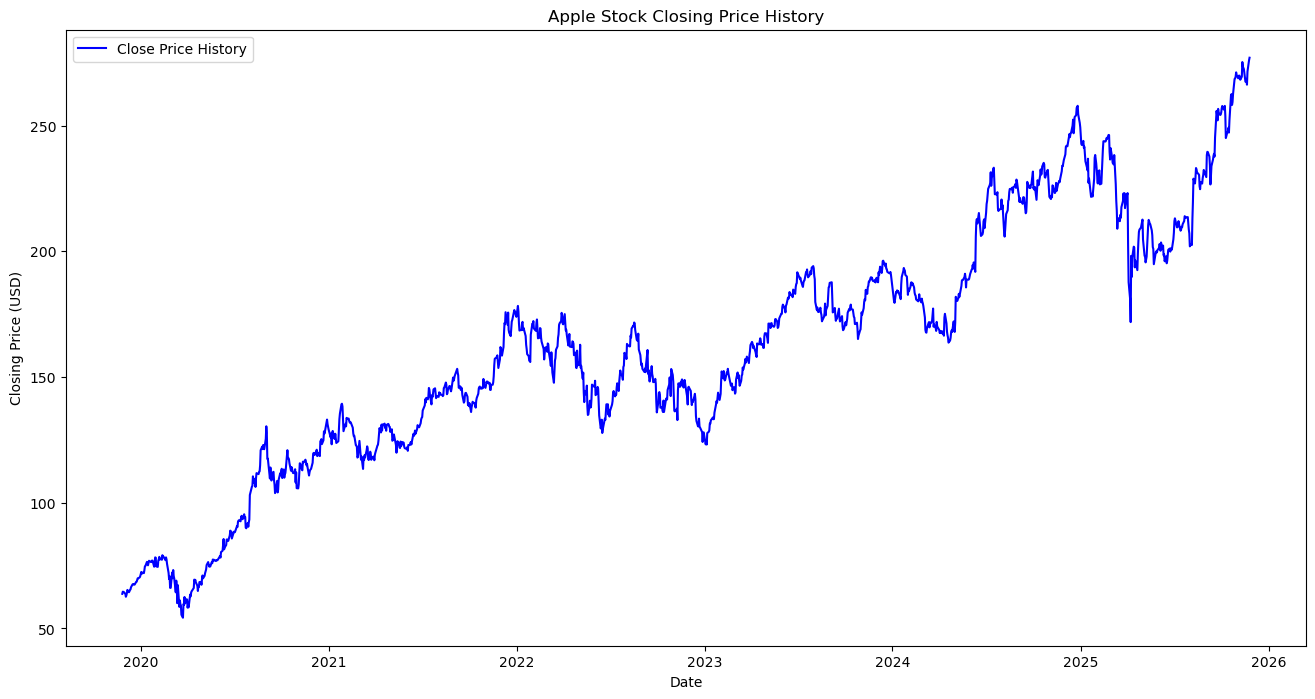

In [11]:
plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Close Price History', color='blue')
plt.title("Apple Stock Closing Price History")
plt.xlabel("Date")
plt.ylabel("Closing Price (USD)")
plt.legend()
plt.show()


In [ ]:
STEP 2 -- Preprocess Data and Prepare for LSTM

In [17]:
# Reset index (the current index is the date)
df.reset_index(inplace=True)

# Rename the index column to 'Date' if needed
if 'Date' not in df.columns:
    df.rename(columns={df.columns[0]: 'Date'}, inplace=True)

# Drop columns only if they exist
columns_to_drop = ['Dividends', 'Stock Splits']
df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)

# Check first 5 rows
df.head()


,index,Date,Open,High,Low,Close,Volume
0,0,2019-11-26 00:00:00-05:00,64.407131,64.460213,63.335850,63.767742,105207600
1,1,2019-11-27 00:00:00-05:00,64.078966,64.658043,64.013823,64.624260,65235600
2,2,2019-11-29 00:00:00-05:00,64.325065,64.662855,64.156167,64.481895,46617600
3,3,2019-12-02 00:00:00-05:00,64.486734,64.723190,63.565052,63.736359,94487200
4,4,2019-12-03 00:00:00-05:00,62.324864,62.619225,61.837482,62.599926,114430400


In [19]:
# Sort the data by date
data = df.sort_index(ascending=True, axis=0)

# Create new DataFrame with only 'Date' and 'Close'
df1 = pd.DataFrame()
df1['Date'] = data['Date']
df1['Close'] = data['Close']

# Set 'Date' as index
df1.set_index('Date', inplace=True)

# Display first 5 rows
df1.head()


,Close
Date,
2019-11-26 00:00:00-05:00,63.767742
2019-11-27 00:00:00-05:00,64.624260
2019-11-29 00:00:00-05:00,64.481895
2019-12-02 00:00:00-05:00,63.736359
2019-12-03 00:00:00-05:00,62.599926


In [21]:
# Convert DataFrame to numpy array
dataset = df1.values

# Define train and test split (e.g., 70% train, 30% test)
train_size = int(len(dataset) * 0.7)
train = dataset[:train_size]
test = dataset[train_size:]

print("Train shape:", train.shape)
print("Test shape:", test.shape)


Train shape: (1055, 1)
Test shape: (453, 1)


In [23]:
# Scale data to range 0-1
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)


In [25]:
# Create sequences of 60 days
x_train, y_train = [], []
window_size = 60

for i in range(window_size, len(train)):
    x_train.append(scaled_data[i-window_size:i, 0])
    y_train.append(scaled_data[i, 0])

# Convert to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape for LSTM [samples, timesteps, features]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


In [27]:
# Prepare test inputs
inputs = scaled_data[len(scaled_data) - len(test) - window_size:]
x_test = []

for i in range(window_size, len(inputs)):
    x_test.append(inputs[i-window_size:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


In [ ]:
Step 3 -- Build & Train LSTM Model

In [37]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
import math
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


In [39]:
# Initialize the model
model = Sequential()

# First LSTM layer with 50 units and return sequences
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))

# Second LSTM layer
model.add(LSTM(units=50))

# Output layer
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Summary of the model
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
# Train the model on training data
history = model.fit(x_train, y_train, epochs=10, batch_size=64, verbose=2)


Epoch 1/10
16/16 - 1s - 88ms/step - loss: 0.0421
Epoch 2/10
16/16 - 0s - 17ms/step - loss: 0.0051
Epoch 3/10
16/16 - 0s - 16ms/step - loss: 0.0024
Epoch 4/10
16/16 - 0s - 16ms/step - loss: 0.0013
Epoch 5/10
16/16 - 0s - 16ms/step - loss: 8.9377e-04
Epoch 6/10
16/16 - 0s - 17ms/step - loss: 7.2337e-04
Epoch 7/10
16/16 - 0s - 19ms/step - loss: 7.0062e-04
Epoch 8/10
16/16 - 0s - 18ms/step - loss: 6.8696e-04
Epoch 9/10
16/16 - 0s - 19ms/step - loss: 6.8537e-04
Epoch 10/10
16/16 - 0s - 19ms/step - loss: 6.7172e-04


In [45]:
# Ensure 'window' is defined
window = 60  # sequence length used in training

# Predict on training and test sets
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

# Inverse transform predictions to original scale
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# True values of test set
actual_test = scaler.inverse_transform(inputs[window:])


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [47]:
# Calculate Root Mean Squared Error (RMSE) for test data
rmse = math.sqrt(mean_squared_error(actual_test, test_predict))
print(f"Root Mean Squared Error: {rmse}")


Root Mean Squared Error: 10.204269671846957


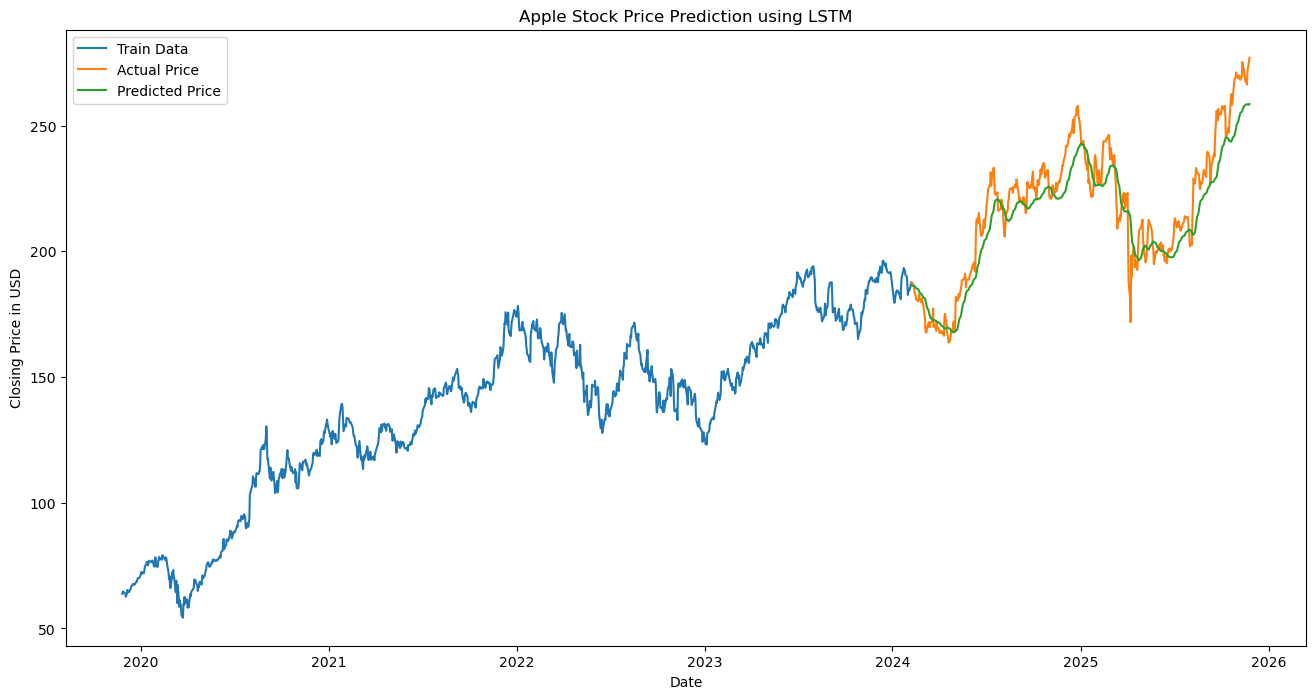

In [49]:
# Prepare data for plotting
train_dates = df1.index[:len(train)]
test_dates = df1.index[len(train):]

plt.figure(figsize=(16,8))
plt.plot(train_dates, df1['Close'][:len(train)], label='Train Data')
plt.plot(test_dates, df1['Close'][len(train):], label='Actual Price')
plt.plot(test_dates, test_predict, label='Predicted Price')
plt.xlabel('Date')
plt.ylabel('Closing Price in USD')
plt.title('Apple Stock Price Prediction using LSTM')
plt.legend()
plt.show()
